In [1]:
import os
import sys
sys.path.append('../../')

In [41]:
import pandas as pd
from src.utils import get_db_con
from src.analysis_functions import (
    get_all_decisions, groups, schemas, users, dps, dt, pdr, group_order, colors, 
    assign_conf_mat_cell, _modify_value_and_time
)

In [3]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [4]:
cred_file = '../../conf/credentials.yaml'
conn = get_db_con(cred_file)

#### Fetch All transactions/decisions

In [9]:
%%capture
all_decisions = get_all_decisions(conn, schemas, users, groups)

In [10]:
all_decisions.head()

,xplz_id,group,user_name,trx_amnt,decision,decision_time,label
0,0005e73512cc6b51164de77a492947cb,ML Model,j,206.86,approved,24,0.0
1,00199cf0e179eee21bbc464dfdd26695,Irrelevant,n,102.69,approved,126,1.0
2,0023ade89e3b6dedae14bced27d2e02a,Data,n,88.78,approved,61,0.0
3,0053a4cc33ce725779c115d4c8fe392b,ML Model,j,137.94,approved,8,0.0
4,005ba4ef23b2226267fe9ab620fe1d10,Irrelevant,t,190.00,approved,39,0.0


<AxesSubplot: >

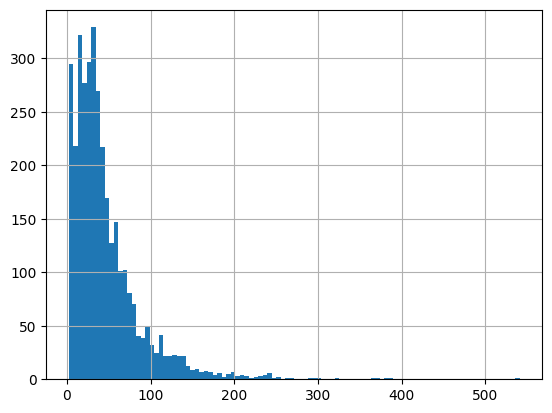

In [92]:
all_decisions.decision_time.hist(bins=100)

In [48]:
all_decisions['conf_cell'] = assign_conf_mat_cell(all_decisions, suspicious_strategy='correct') 

In [49]:
params={
    'fn': -3, 
    'p_loss_trx': 0.5, # prob of losing this transaction
    'cust_worth': 3, # The long term customer worth as a coefficiant of the trx val
    'p_loss_cust': 0.1, # probablity of losing the customer due to the rejection
    'p_return_cust': 1, # probability of the customer creating future worth as we expect
    'suspicious_add_time': 600
}

In [50]:
all_decisions = _modify_value_and_time(all_decisions, params, 'correct')

In [80]:
msk = all_decisions['trx_amnt'] > 0 
all_decisions = all_decisions[msk]

In [81]:
all_decisions['potential_revenue'] = all_decisions.apply(
    lambda x: x['trx_amnt'] * (1 + (params['cust_worth'] * params['p_return_cust'])) if x['label']==0 else 0, 
    axis=1
)

/tmp/ipykernel_31878/3701354669.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_decisions['potential_revenue'] = all_decisions.apply(


In [83]:
all_decisions['regret'] = all_decisions.apply(
    lambda x: 1 - (x['decision_value'] / x['potential_revenue']) if x['label']==0 else 0, 
    axis=1
)
# 1 - all_decisions['decision_value'] / all_decisions['decision_value']

/tmp/ipykernel_31878/3602972955.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_decisions['regret'] = all_decisions.apply(


In [87]:
msk = all_decisions['decision_value'] < 0
all_decisions.loc[msk, 'regret'] = 1

In [88]:
all_decisions

,xplz_id,group,user_name,trx_amnt,decision,decision_time,label,conf_cell,conf_mat,decision_value,modified_time,potential_revenue,regret
0,0005e73512cc6b51164de77a492947cb,ML Model,j,206.86,approved,24,0.0,tn,tn,827.44,24,827.44,0.0
1,00199cf0e179eee21bbc464dfdd26695,Irrelevant,n,102.69,approved,126,1.0,fn,fn,-308.07,126,0.00,1.0
2,0023ade89e3b6dedae14bced27d2e02a,Data,n,88.78,approved,61,0.0,tn,tn,355.12,61,355.12,0.0
3,0053a4cc33ce725779c115d4c8fe392b,ML Model,j,137.94,approved,8,0.0,tn,tn,551.76,8,551.76,0.0
4,005ba4ef23b2226267fe9ab620fe1d10,Irrelevant,t,190.00,approved,39,0.0,tn,tn,760.00,39,760.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3475,ff77551516ec6697d57a3cd27b0f3a83,TreeInt,j,128.00,approved,4,0.0,tn,tn,512.00,4,512.00,0.0
3476,ff870623958495f4db39fdc9410e379f,Random,t,800.00,approved,19,0.0,tn,tn,3200.00,19,3200.00,0.0
3477,ff90b767a3da182e3399ee8ad856fa12,TreeInt,n,353.31,approved,60,0.0,tn,tn,1413.24,60,1413.24,0.0
3479,fff66c84678648b09168e4a635f276f3,TreeInt,t,319.31,declined,45,1.0,tp,tp,0.00,45,0.00,0.0


## Hypotheses
trx_amnt tested several hypotheses
- Model vs Data
- Each explainer vs model
- Each explainer against each other
- Each explainer vs radom/irrelevant


### Decision Time

In [62]:
def fit_linear_model_for_pairwise_test(all_decisions, variants_to_compare, column, linear_model):
    relevant_features = ['user_name', 'group', column, 'trx_amnt']
    
    group1 = variants_to_compare[0]
    group2 = variants_to_compare[1]
    
    row_filter = (all_decisions['group'] == group1) | (all_decisions['group'] == group2)
    
    df = all_decisions[row_filter][relevant_features]
    dummified = pd.get_dummies(df)
    
    y = dummified[column]
    X = dummified.drop(columns=column)

    scaler = MinMaxScaler().fit(X)
    x_scaled = scaler.transform(X)
    
    mod = linear_model.fit(x_scaled, y)

    feature_importance = dict()
    for i in range(mod.coef_.shape[0]):
        feature_importance[X.columns[i]] = mod.coef_[i]
    
    
    return pd.Series(feature_importance).sort_values()
    
    

In [64]:
fit_linear_model_for_pairwise_test(all_decisions, ('ML Model', 'Data'), 'modified_time', Ridge())

user_name_j      -30.371420
group_ML Model   -13.937145
user_name_n       13.512918
group_Data        13.937145
user_name_t       16.858503
trx_amnt          41.982625
dtype: float64

In [65]:
fit_linear_model_for_pairwise_test(all_decisions, ('TreeSHAP', 'ML Model'), 'modified_time', Ridge())

user_name_j      -24.300472
group_ML Model    -7.950530
user_name_n        6.185428
group_TreeSHAP     7.950530
user_name_t       18.115044
trx_amnt          83.052338
dtype: float64

In [66]:
fit_linear_model_for_pairwise_test(all_decisions, ('LIME', 'ML Model'), 'modified_time', Ridge())

user_name_j      -30.627575
group_ML Model    -3.133824
group_LIME         3.133824
user_name_n        8.515044
user_name_t       22.112531
trx_amnt          60.016547
dtype: float64

In [67]:
fit_linear_model_for_pairwise_test(all_decisions, ('TreeInt', 'ML Model'), 'modified_time', Ridge())

user_name_j      -32.352225
group_ML Model    -7.113395
group_TreeInt      7.113395
user_name_t        9.904155
user_name_n       22.448070
trx_amnt          63.595129
dtype: float64

In [69]:
fit_linear_model_for_pairwise_test(all_decisions, ('TreeInt', 'Irrelevant'),'modified_time', Ridge())

user_name_j         -36.057953
user_name_t          -6.341611
group_Irrelevant     -2.082089
group_TreeInt         2.082089
user_name_n          42.399564
trx_amnt            173.546969
dtype: float64

In [70]:
fit_linear_model_for_pairwise_test(all_decisions, ('TreeInt', 'Random'), 'modified_time', Ridge())

user_name_j      -35.241664
group_Random      -4.742141
user_name_t       -3.473070
group_TreeInt      4.742141
user_name_n       38.714734
trx_amnt         103.093762
dtype: float64

### Regret

In [89]:
fit_linear_model_for_pairwise_test(all_decisions, ('ML Model', 'Data'), 'regret', Ridge())

trx_amnt         -0.098860
user_name_n      -0.019088
user_name_t      -0.015060
group_ML Model   -0.005071
group_Data        0.005071
user_name_j       0.034148
dtype: float64

In [90]:
fit_linear_model_for_pairwise_test(all_decisions, ('ML Model', 'LIME'), 'regret', Ridge())

trx_amnt         -0.010999
user_name_n      -0.010444
group_ML Model   -0.005324
user_name_t      -0.003453
group_LIME        0.005324
user_name_j       0.013898
dtype: float64

### Using all experimental conditions together 

In [105]:
regression_features = ['user_name', 'group', 'decision_time', 't']

# regression_features = [ 'group', 'decision_time']

all_decisions[regression_features].head()

,user_name,group,decision_time
0,j,ML Model,24
1,n,Irrelevant,126
2,n,Data,61
3,j,ML Model,8
4,t,Irrelevant,39


In [106]:
dummified = pd.get_dummies(all_decisions[regression_features])

In [107]:
y = dummified['decision_time']
X = dummified.drop(columns='decision_time')

In [108]:
# train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0)

In [109]:
scaler = MinMaxScaler().fit(X)
x_scaled = scaler.transform(X)

#### Unregularized Linear Regression

In [110]:
mod = LinearRegression().fit(x_scaled, y)

feature_importance = dict()
for i in range(mod.coef_.shape[0]):
    feature_importance[X.columns[i]] = mod.coef_[i]
pd.Series(feature_importance).sort_values()

group_ML Model     -2.459101e+15
group_LIME         -2.459101e+15
group_Data         -2.459101e+15
group_TreeInt      -2.459101e+15
group_TreeSHAP     -2.459101e+15
group_Irrelevant   -2.459101e+15
group_Random       -2.459101e+15
user_name_j         4.658508e+14
user_name_t         4.658508e+14
user_name_n         4.658508e+14
dtype: float64

#### L1

In [103]:
mod = Lasso().fit(x_scaled, y)

feature_importance = dict()
for i in range(mod.coef_.shape[0]):
    feature_importance[X.columns[i]] = mod.coef_[i]

pd.Series(feature_importance).sort_values()

user_name_j        -21.099677
group_ML Model      -1.143280
user_name_t         -0.000000
group_Data          -0.000000
group_Irrelevant     0.000000
group_LIME          -0.000000
group_Random         0.000000
group_TreeInt        0.000000
group_TreeSHAP       0.000000
user_name_n         23.148124
dtype: float64

#### L2

In [104]:
mod = Ridge().fit(x_scaled, y)

feature_importance = dict()
for i in range(mod.coef_.shape[0]):
    feature_importance[X.columns[i]] = mod.coef_[i]

pd.Series(feature_importance).sort_values()

user_name_j        -24.746567
group_ML Model      -7.938153
group_LIME          -4.086523
group_Data          -1.875893
user_name_t         -0.692205
group_TreeSHAP       1.848526
group_TreeInt        2.589683
group_Random         3.104993
group_Irrelevant     6.357368
user_name_n         25.438772
dtype: float64

In [70]:
all_decisions_2

,Transaction ID,Transaction Amount (USD),Fraud Label,Analyst ID,Experimental Arm,Analyst Decision,Decision Time (seconds),Perceived Confidence,Perceived Information
0,1,207.85,0,1,Control (Scores),approved,24,High confidence,Medium information
1,2,88.50,0,2,Control (No Scores),approved,61,High confidence,High information
2,3,139.24,0,1,Control (Scores),approved,8,Certainty,High information
3,4,165.85,0,3,Control (No Scores),approved,26,High confidence,Low information
4,5,159.53,0,3,Control (Scores),approved,16,High confidence,Low information
...,...,...,...,...,...,...,...,...,...
3458,531,177.68,1,3,Irrelevant Features,approved,38,High confidence,Low information
3459,462,190.87,1,3,Random Model Features,approved,30,High confidence,No information
3460,405,441.04,1,3,Random Model Features,declined,35,Certainty,No information
3461,496,112.91,0,3,Random Model Features,approved,24,High confidence,No information


In [96]:
all_decisions_2.groupby(['Analyst ID', 'Experimental Arm']).mean()['Decision Time (seconds)']

/tmp/ipykernel_25415/1154419150.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  all_decisions_2.groupby(['Analyst ID', 'Experimental Arm']).mean()['Decision Time (seconds)']


Analyst ID  Experimental Arm     
1           Control (No Scores)      24.865854
            Control (Scores)         20.066667
            Irrelevant Features      22.536585
            LIME                     16.500000
            Random Model Features    19.877301
            SHAP                     28.206061
            TreeInterpreter          17.298780
2           Control (No Scores)      61.654545
            Control (Scores)         56.442424
            Irrelevant Features      89.981928
            LIME                     62.251497
            Random Model Features    79.248485
            SHAP                     71.012048
            TreeInterpreter          80.393939
3           Control (No Scores)      46.098160
            Control (Scores)         38.103659
            Irrelevant Features      45.161677
            LIME                     47.198795
            Random Model Features    48.524390
            SHAP                     44.733333
            TreeInterprete

## Evaluating Hypotheses

#### H1: Model vs Data